In [1]:
import gzip, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import nibabel as nib
from nilearn.image import resample_to_img
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import _load_autoencoder, _load_masker

In [2]:
# Load model and masker
autoencoder = _load_autoencoder().to("cpu")
masker = _load_masker()

In [3]:
# Load pubmed test set
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()
X_pubmed_masked = neuro_vectors[pd.Series(pmids).isin(test)].to("cpu")

np.random.seed(0)
inds = np.random.choice(np.arange(len(X_pubmed_masked)), 8)

X_pubmed_masked = X_pubmed_masked[inds]
X_pubmed = [masker.inverse_transform(i) for i in X_pubmed_masked.cpu().numpy()]

In [4]:
# Load network atlases
with gzip.open(data_dir / "networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

network_imgs = []
for k in networks.keys():
    for a in networks[k].keys():
        network_imgs.append((k, a, nib.Nifti1Image(networks[k][a]["array"], affine=networks[k][a]["affine"])))

networks = [i for i in network_imgs if i[0] not in ["UKBICA", "HCPICA"]]

df = pd.read_csv(data_dir / "network_examples.csv")
inds = df["Unnamed: 0"].values

X_networks_masked = torch.load(data_dir / "networks_emb.pt")
X_networks_masked = X_networks_masked[inds]

X_networks = [
    resample_to_img(net[2], masker.mask_img, force_resample=True, copy_header=True)
    for i, net in enumerate([networks[i] for i in inds])
]

<positron-console-cell-4>:19: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
<positron-console-cell-4>:19: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
<positron-console-cell-4>:19: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
<positron-console-cell-4>:19: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
<positron-console-cell-4>:19: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest int

In [5]:
# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, _ = neurovault_data.values()

np.random.seed(1)
inds = np.random.choice(np.arange(len(neuro_clust)), 8)

X_neurovault_masked = torch.tensor(neuro_clust[inds])
X_neurovault = [masker.inverse_transform(i) for i in neuro_clust[inds]]

In [6]:
with torch.no_grad():
    X_networks_re = torch.sigmoid(autoencoder.decoder(X_networks_masked)).detach().numpy()
    X_pubmed_re = torch.sigmoid(autoencoder(X_pubmed_masked)).detach().numpy()
    X_neurovault_re = torch.sigmoid(autoencoder(X_neurovault_masked)).detach().numpy()

In [7]:
X_networks_re = [masker.inverse_transform(i) for i in X_networks_re]
X_pubmed_re = [masker.inverse_transform(i) for i in X_pubmed_re]
X_neurovault_re = [masker.inverse_transform(i) for i in X_neurovault_re]

In [8]:
from nilearn.plotting import plot_stat_map

In [9]:
def plot_set(X, X_re, row, axes):

    for i in range(len(X)):
        ijk = np.unravel_index(np.argmax(X_re[i].get_fdata()),
                        X_re[i].shape)

        xyz = nib.affines.apply_affine(X_re[i].affine, ijk)

        plot_stat_map(X[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row, i])

        plot_stat_map(X_re[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row+1, i])

# fig, axes = plt.subplots(nrows=2, ncols=24, figsize=(18, 2))
# plot_set(X_networks, X_networks_re, 0, axes)

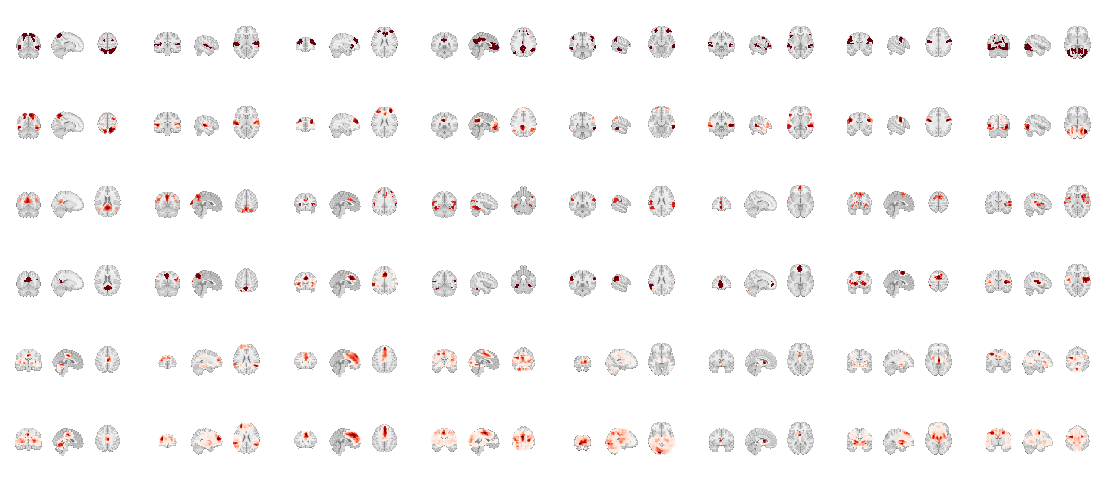

In [10]:
fig, axes = plt.subplots(nrows=int(2*3), ncols=8, figsize=(14, 6))
plot_set(X_networks, X_networks_re, 0, axes)
plot_set(X_neurovault, X_neurovault_re, 2, axes)
plot_set(X_pubmed, X_pubmed_re, 4, axes)
plt.savefig(data_dir / "autoencoder_examples.svg")

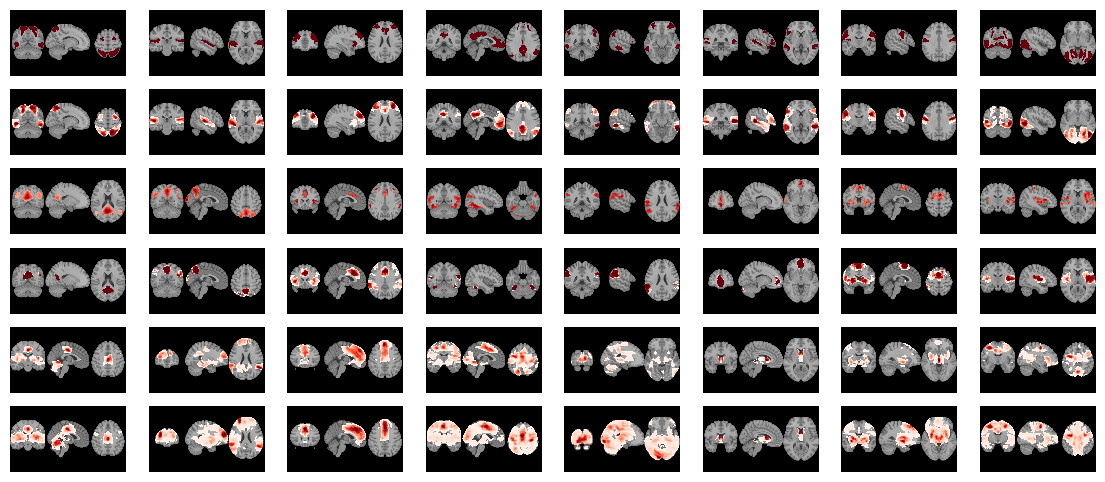

In [11]:
from nilearn import datasets
bg = datasets.load_mni152_template(resolution=4)

def plot_set(X, X_re, row, axes):

    for i in range(len(X)):
        ijk = np.unravel_index(np.argmax(X_re[i].get_fdata()),
                        X_re[i].shape)

        xyz = nib.affines.apply_affine(X_re[i].affine, ijk)

        plot_stat_map(X[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False, bg_img=bg,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row, i])

        plot_stat_map(X_re[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False, bg_img=bg,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row+1, i])

# fig, axes = plt.subplots(nrows=2, ncols=24, figsize=(18, 2))
# plot_set(X_networks, X_networks_re, 0, axes)

fig, axes = plt.subplots(nrows=int(2*3), ncols=8, figsize=(14, 6))
plot_set(X_networks, X_networks_re, 0, axes)
plot_set(X_neurovault, X_neurovault_re, 2, axes)
plot_set(X_pubmed, X_pubmed_re, 4, axes)
plt.savefig(data_dir / "autoencoder_examples_highres.svg")

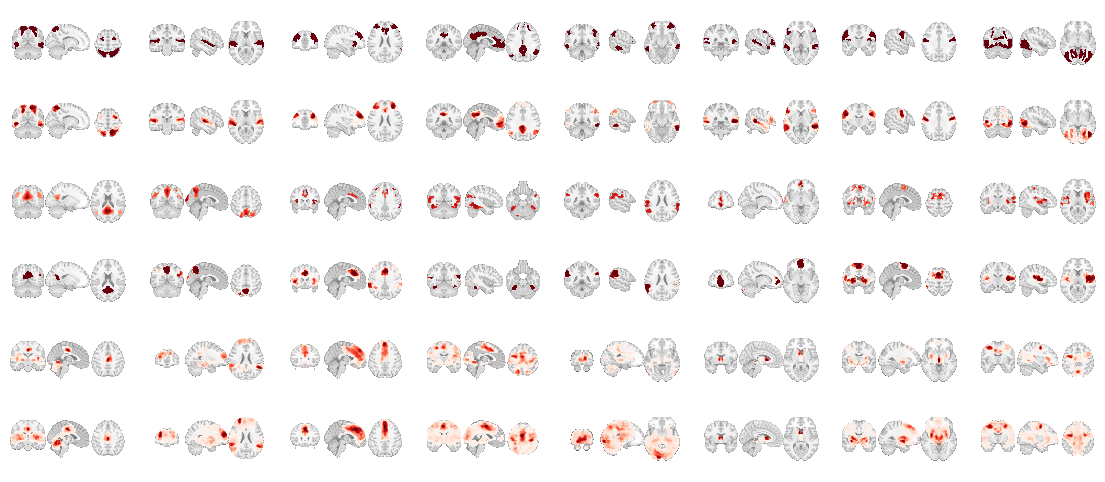

In [13]:
from nilearn import datasets
bg = datasets.load_mni152_template(resolution=4)

def plot_set(X, X_re, row, axes):

    for i in range(len(X)):
        ijk = np.unravel_index(np.argmax(X_re[i].get_fdata()),
                        X_re[i].shape)

        xyz = nib.affines.apply_affine(X_re[i].affine, ijk)

        plot_stat_map(X[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False, bg_img=bg, black_bg=False,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row, i])

        plot_stat_map(X_re[i], vmin=0, cut_coords=xyz, cmap="Reds", annotate=False, bg_img=bg, black_bg=False,
                      colorbar=False, draw_cross=False, threshold=1e-2, axes=axes[row+1, i])

# fig, axes = plt.subplots(nrows=2, ncols=24, figsize=(18, 2))
# plot_set(X_networks, X_networks_re, 0, axes)

fig, axes = plt.subplots(nrows=int(2*3), ncols=8, figsize=(14, 6))
plot_set(X_networks, X_networks_re, 0, axes)
plot_set(X_neurovault, X_neurovault_re, 2, axes)
plot_set(X_pubmed, X_pubmed_re, 4, axes)
plt.savefig(data_dir / "autoencoder_examples_highres_.svg")